**1. Get the Data**

!pip install kaggle

In [15]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)

In [21]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting


  0%|          | 0.00/2.70M [00:00<?, ?B/s]
 37%|###7      | 1.00M/2.70M [00:01<00:01, 898kB/s]
 74%|#######4  | 2.00M/2.70M [00:01<00:00, 1.72MB/s]
100%|##########| 2.70M/2.70M [00:01<00:00, 2.37MB/s]
100%|##########| 2.70M/2.70M [00:01<00:00, 1.88MB/s]


In [23]:
import zipfile

with zipfile.ZipFile("walmart-recruiting-store-sales-forecasting.zip", "r") as zip_ref:
    zip_ref.extractall("walmart_data")

# List extracted files
os.listdir("walmart_data")

['features.csv.zip',
 'sampleSubmission.csv.zip',
 'stores.csv',
 'test.csv.zip',
 'train.csv.zip']

**2. Data Preparation**

In [9]:
import pandas as pd

# Load datasets
train_df = pd.read_csv("walmart_data/train.csv")
test_df = pd.read_csv("walmart_data/test.csv")
stores_df = pd.read_csv("walmart_data/stores.csv")
features_df = pd.read_csv("walmart_data/features.csv")

# Display first few rows of each dataset
print("Train Data:")
display(train_df.head())

print("\nTest Data:")
display(test_df.head())

print("\nStores Data:")
display(stores_df.head())

print("\nFeatures Data:")
display(features_df.head())

Train Data:


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False



Test Data:


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False



Stores Data:


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875



Features Data:


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [11]:
# Merge train data with features and store info
train_df = train_df.merge(features_df, on=["Store", "Date"], how="left")
train_df = train_df.merge(stores_df, on=["Store"], how="left")

# Merge test data with features and store info
test_df = test_df.merge(features_df, on=["Store", "Date"], how="left")
test_df = test_df.merge(stores_df, on=["Store"], how="left")

In [13]:
# Check for missing values
missing_values = train_df.isnull().sum()
print(missing_values[missing_values > 0])

MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64


In [15]:
# Fill missing Markdown values with 0 (assuming no markdowns happened)
train_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = \
train_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0)

# Fill missing CPI and Unemployment values with median
train_df.loc[:, "CPI"] = train_df["CPI"].fillna(train_df["CPI"].median())
train_df.loc[:, "Unemployment"] = train_df["Unemployment"].fillna(train_df["Unemployment"].median())

In [17]:
# Convert 'Date' column to datetime format
train_df["Date"] = pd.to_datetime(train_df["Date"])

# Extract new time-based features
train_df["Year"] = train_df["Date"].dt.year
train_df["Month"] = train_df["Date"].dt.month
train_df["Week"] = train_df["Date"].dt.isocalendar().week
train_df["DayOfWeek"] = train_df["Date"].dt.dayofweek  # Monday = 0, Sunday = 6
train_df["IsWeekend"] = (train_df["DayOfWeek"] >= 5).astype(int)  # 1 if Sat/Sun, else 0

# Encode 'IsHoliday' as numeric (0 = Non-Holiday, 1 = Holiday)
train_df["IsHoliday_y"] = train_df["IsHoliday_y"].astype(int)

# Drop the original 'Date' column as it's no longer needed
train_df.drop(columns=["Date"], inplace=True)

print(train_df.head())

   Store  Dept  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  MarkDown1  \
0      1     1      24924.50        False        42.31       2.572        0.0   
1      1     1      46039.49         True        38.51       2.548        0.0   
2      1     1      41595.55        False        39.93       2.514        0.0   
3      1     1      19403.54        False        46.63       2.561        0.0   
4      1     1      21827.90        False        46.50       2.625        0.0   

   MarkDown2  MarkDown3  MarkDown4  ...         CPI  Unemployment  \
0        0.0        0.0        0.0  ...  211.096358         8.106   
1        0.0        0.0        0.0  ...  211.242170         8.106   
2        0.0        0.0        0.0  ...  211.289143         8.106   
3        0.0        0.0        0.0  ...  211.319643         8.106   
4        0.0        0.0        0.0  ...  211.350143         8.106   

   IsHoliday_y  Type    Size  Year  Month  Week  DayOfWeek  IsWeekend  
0            0     A  1513

In [19]:
# Convert 'Date' column to datetime format
test_df["Date"] = pd.to_datetime(test_df["Date"])

# Extract new time-based features
test_df["Year"] = test_df["Date"].dt.year
test_df["Month"] = test_df["Date"].dt.month
test_df["Week"] = test_df["Date"].dt.isocalendar().week
test_df["DayOfWeek"] = test_df["Date"].dt.dayofweek  # Monday = 0, Sunday = 6
test_df["IsWeekend"] = (test_df["DayOfWeek"] >= 5).astype(int)  # 1 if Sat/Sun, else 0

# Encode 'IsHoliday' as numeric (0 = Non-Holiday, 1 = Holiday)
test_df["IsHoliday_y"] = test_df["IsHoliday_y"].astype(int)

# Drop the original 'Date' column as it's no longer needed
test_df.drop(columns=["Date"], inplace=True)

print(test_df.head())

   Store  Dept  IsHoliday_x  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1     1        False        55.32       3.386    6766.44    5147.70   
1      1     1        False        61.24       3.314   11421.32    3370.89   
2      1     1        False        52.92       3.252    9696.28     292.10   
3      1     1         True        56.23       3.211     883.59       4.17   
4      1     1        False        52.34       3.207    2460.03        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday_y  \
0      50.82    3639.90    2737.42  223.462779         6.573            0   
1      40.28    4646.79    6154.16  223.481307         6.573            0   
2     103.78    1133.15    6612.69  223.512911         6.573            0   
3   74910.32     209.91     303.32  223.561947         6.573            1   
4    3838.35     150.57    6966.34  223.610984         6.573            0   

  Type    Size  Year  Month  Week  DayOfWeek  IsWeekend  
0    A  15

**3. EDA**

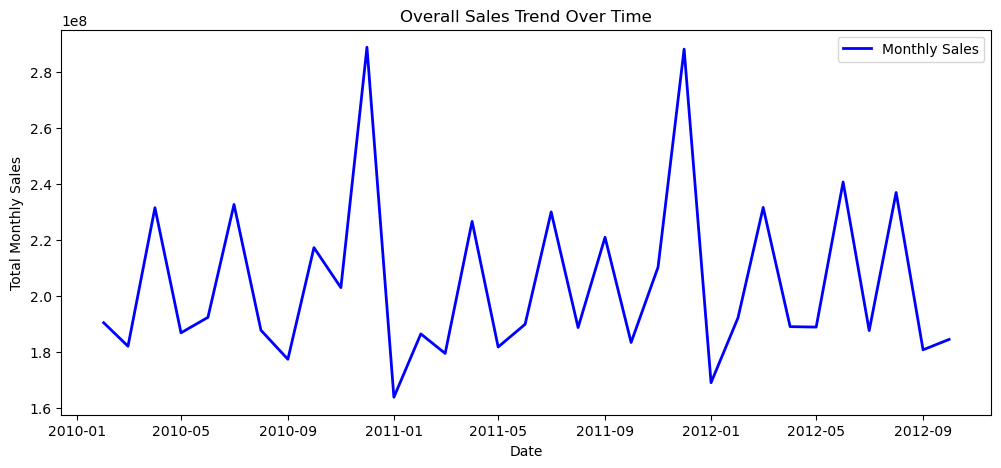

In [22]:
import matplotlib.pyplot as plt

#Time-based sales trend
sales_trend = train_df.groupby(["Year", "Month"])["Weekly_Sales"].sum().reset_index()

# Convert Year-Month to datetime for plotting
sales_trend["YearMonth"] = pd.to_datetime(sales_trend[["Year", "Month"]].assign(day=1))

# Plot overall sales trend
plt.figure(figsize=(12, 5))
plt.plot(sales_trend["YearMonth"], sales_trend["Weekly_Sales"], color="blue", linestyle="-", linewidth=2, label="Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Total Monthly Sales")
plt.title("Overall Sales Trend Over Time")
plt.legend()
plt.show()

C:\Users\Abdillahi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


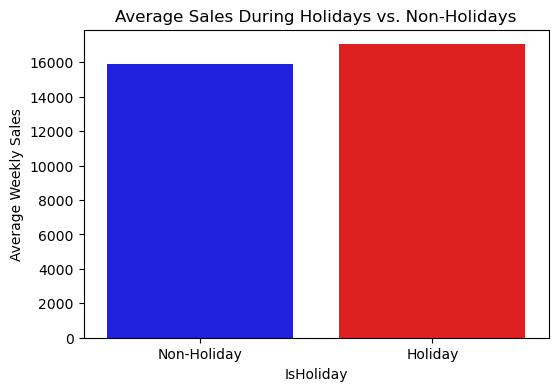

In [24]:
import seaborn as sns

# Compare average sales on holidays vs. non-holidays
holiday_sales = train_df.groupby("IsHoliday_y")["Weekly_Sales"].mean()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=["Non-Holiday", "Holiday"], y=holiday_sales.values, palette=["blue", "red"])
plt.ylabel("Average Weekly Sales")
plt.xlabel("IsHoliday")
plt.title("Average Sales During Holidays vs. Non-Holidays")
plt.show()

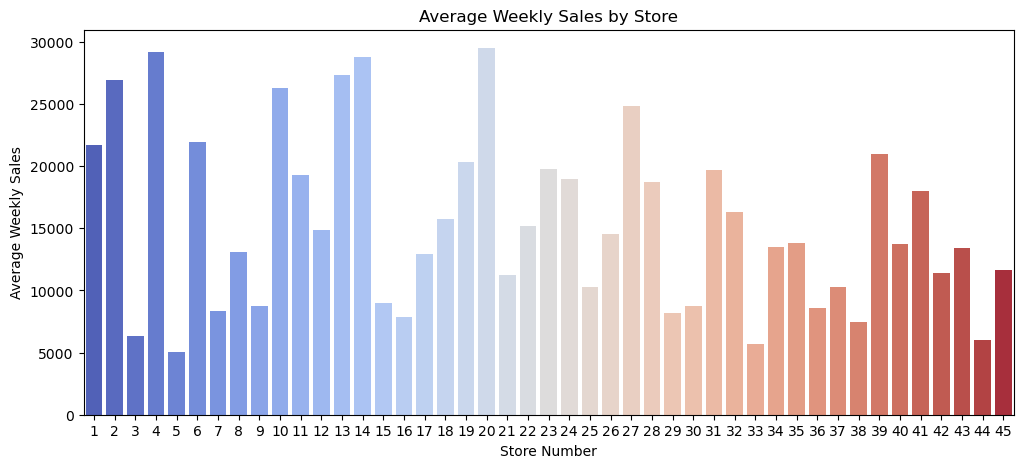

In [26]:
import seaborn as sns

# Group by store number and calculate average weekly sales
store_sales = train_df.groupby("Store")["Weekly_Sales"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x="Store", y="Weekly_Sales", data=store_sales, palette="coolwarm")
plt.xlabel("Store Number")
plt.ylabel("Average Weekly Sales")
plt.title("Average Weekly Sales by Store")
plt.show()

C:\Users\Abdillahi\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


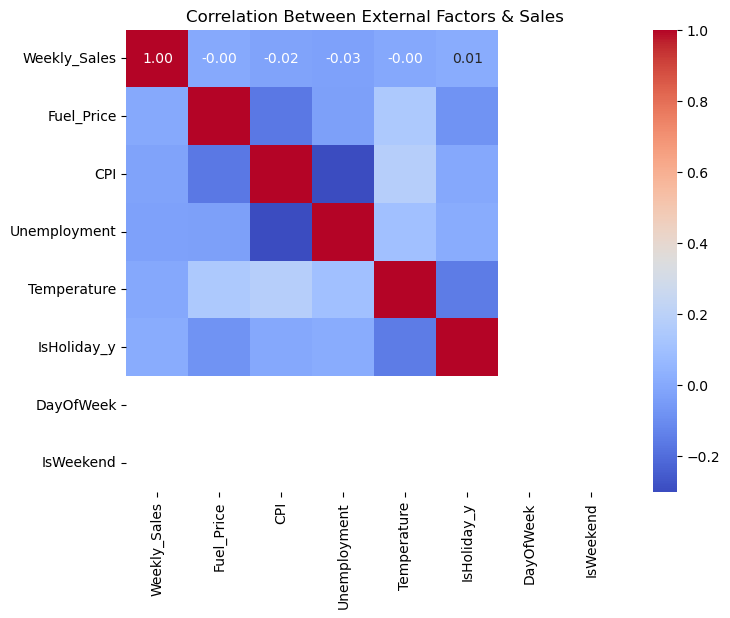

In [28]:
# Select numeric features for correlation
correlation_features = ["Weekly_Sales", "Fuel_Price", "CPI", "Unemployment", "Temperature", "IsHoliday_y", "DayOfWeek", "IsWeekend"]

# Compute correlation matrix
correlation_matrix = train_df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between External Factors & Sales")
plt.show()

**3. XGBoost Model**

In [31]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Define feature columns (excluding target variable 'Weekly_Sales' in training data)
feature_cols = [col for col in train_df.columns if col not in ["Weekly_Sales", "Date"]]

# Extract features and target
X = train_df[feature_cols]
y = train_df["Weekly_Sales"]

# Apply the same feature engineering to the test dataset
X_test = test_df[feature_cols]

In [33]:
# Define feature columns (excluding target variable 'Weekly_Sales')
feature_cols = ['Store', 'Dept', 'Year', 'Month', 'Week', 'DayOfWeek', 'IsWeekend', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Extract features and target variable
X = train_df[feature_cols]
y = train_df["Weekly_Sales"]

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Define XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression objective
    n_estimators=500,              # Number of trees
    learning_rate=0.05,            # Step size shrinkage
    max_depth=6,                   # Depth of trees
    subsample=0.8,                 # Random subset of data
    colsample_bytree=0.8,          # Random subset of features
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
import numpy as np

# Predict on validation set
y_pred = xgb_model.predict(X_val)

# Calculate performance metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
explained_var = explained_variance_score(y_val, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")

Mean Absolute Error (MAE): 4368.2150
Root Mean Squared Error (RMSE): 7316.6269
R-squared (R2 Score): 0.8973
Mean Absolute Percentage Error (MAPE): 4993676239328507.0000
Explained Variance Score: 0.8973


In [39]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,  
    learning_rate=0.05,  
    max_depth=6,  
    num_leaves=31,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    random_state=42
)

# Train the model
lgb_model.fit(X_train, y_train)

# Predictions
y_pred = lgb_model.predict(X_val)

# Evaluate performance
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 9
[LightGBM] [Info] Start training from score 15979.221909
Mean Absolute Error (MAE): 3919.0776
Root Mean Squared Error (RMSE): 6567.0659
R-squared (R2 Score): 0.9173


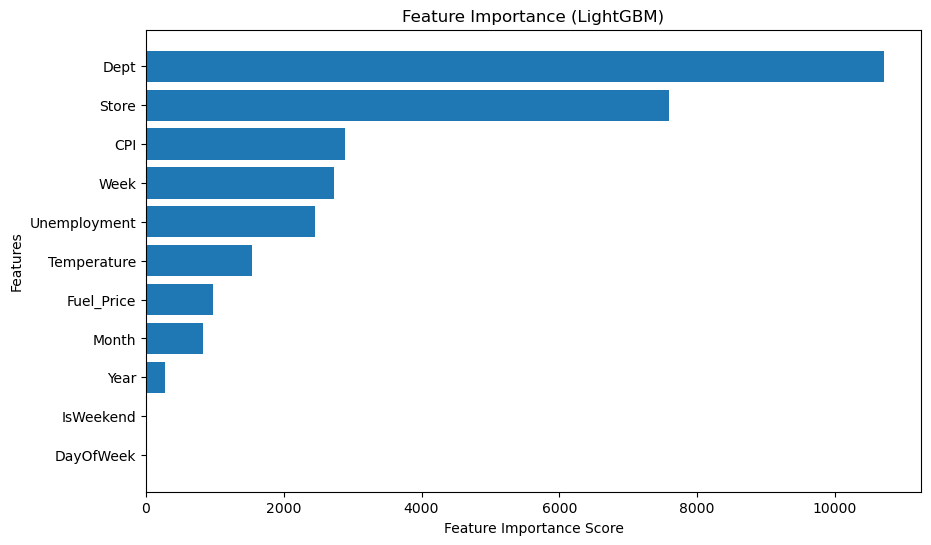

In [41]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np

# Get feature importance from the trained model
feature_importance = lgb_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (LightGBM)")
plt.show()

In [43]:
import joblib

# Save the model
joblib.dump(lgb_model, "lgbm_model.pkl")

# Load the model later
loaded_model = joblib.load("lgbm_model.pkl")

In [45]:
train_df.to_csv("train_preprocessed.csv", index=False)
test_df.to_csv("test_preprocessed.csv", index=False)